# RecursiveCharacterTextSplitter chunk size 500 overlap 100

In [7]:
import pandas as pd
from src.config import CLEAN_FILE_PATH, EVAL_FILE_PATH
import src.utils as utils

data = pd.read_parquet(str(CLEAN_FILE_PATH))
clean_file = str(CLEAN_FILE_PATH)
eval_file = str(EVAL_FILE_PATH)

In [8]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

recursive_text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=100,
    length_function=len,
    is_separator_regex=False,
)

In [9]:
documents = utils.create_documents(data, recursive_text_splitter)

RecursiveCharacterTextSplitter: Documents created: 118062, Rows: 9583, Percentage of doc created: 1231.99%


In [10]:
documents[0]

Document(metadata={'url': 'https://www.energyintel.com/0000017b-a7dc-de4c-a17b-e7de685b0000', 'domain': 'energyintel', 'title': 'Qatar to Slash Emissions as LNG Expansion Advances', 'date': '2021-01-13', 'origin_doc_id': '92151dc1d9bfd38bf55079fd769ba2bb'}, page_content='Qatar Petroleum QP is targeting aggressive cuts in its greenhouse gas emissions as it prepares to launch Phase 2 of its planned 48 million ton per year LNG expansion. In its latest Sustainability Report published on Wednesday, QP said its goals include reducing the emissions intensity of Qatar s LNG facilities by 25 and of its upstream facilities by at least 15 . The company is also aiming to reduce gas flaring intensity across its upstream facilities by more than 75 and has raised its carbon')

In [11]:
from src.custom_embeddings import bge_m3_embed, qwen2_embed, nomic_embed

embedding_models = [bge_m3_embed, qwen2_embed, nomic_embed]

In [12]:
for model in embedding_models:
    print(model.model_name)

    embedding = model.embed_query("The company is also aiming to reduce gas flaring?")

    print(embedding[:20])
    print()

BAAI_bge_m3
[-0.06979186, -0.025753867, -0.03614089, -0.024861958, -0.0046290997, -0.040024407, 0.0053514526, 0.048534703, -0.022353465, 0.04812591, -0.018711504, 0.0028638635, 0.013053457, -0.02528933, 0.019399017, -0.07191015, 0.06280524, -0.033632394, 0.00043143766, -0.0013761874]

Alibaba-NLP_gte-Qwen2-7B
[-0.018390294, 0.012254118, -0.00019189798, -0.0013482721, -0.020569412, 0.0106858825, -0.008780294, -0.019365883, -0.010403235, -0.029067058, 0.0055389707, 0.008411029, 0.0028378677, 0.0095735295, 0.0027125, 0.0008405331, -0.011944118, 0.004219191, 0.0076861763, 0.011488236]

nomic-ai_nomic-embed-text-v1_5
[0.023326509, 0.012770157, -0.20600034, 0.049915466, 0.009018341, -0.0049664956, -0.035630602, 0.011669081, -0.0045382995, -0.051034022, 0.08799291, 0.02442176, 0.080629095, 0.033952773, 0.07275261, -0.0061811754, -0.022289516, -0.016545277, -0.012478867, -0.0034721778]



In [13]:
from src.vectorstorage import EmbeddingVectorStorage


def get_col_name_vectordb_recr(embeddings, text_splitter):

    chunk_size = text_splitter._chunk_size

    name = text_splitter.__class__.__name__
    new_name = name.replace("CharacterText", "")

    return f"{embeddings.model_name}_{new_name}_{chunk_size}"


vector_stores = {}

for model in embedding_models:
    collection_name = get_col_name_vectordb_recr(model, recursive_text_splitter)
    print(f"Collection name: {collection_name}")

    vector_storage = EmbeddingVectorStorage(
        method_of_embedding=model,
        collection=collection_name,
    )

    vector_storage.include_documents(documents, should_verbose=True)

    vector_stores[model.model_name] = vector_storage

print(vector_stores)

Collection name: BAAI_bge_m3_RecursiveSplitter_500
Group BAAI_bge_m3_RecursiveSplitter_500 already exists in the vector storage.
Collection name: Alibaba-NLP_gte-Qwen2-7B_RecursiveSplitter_500
Group Alibaba-NLP_gte-Qwen2-7B_RecursiveSplitter_500 already exists in the vector storage.
Collection name: nomic-ai_nomic-embed-text-v1_5_RecursiveSplitter_500
Group nomic-ai_nomic-embed-text-v1_5_RecursiveSplitter_500 already exists in the vector storage.
{'BAAI_bge_m3': VectorStorage(method_of_embedding=CustomHuggingFaceEndpointEmbeddings, group=BAAI_bge_m3_RecursiveSplitter_500), 'Alibaba-NLP_gte-Qwen2-7B': VectorStorage(method_of_embedding=CustomHuggingFaceEndpointEmbeddings, group=Alibaba-NLP_gte-Qwen2-7B_RecursiveSplitter_500), 'nomic-ai_nomic-embed-text-v1_5': VectorStorage(method_of_embedding=CustomHuggingFaceEndpointEmbeddings, group=nomic-ai_nomic-embed-text-v1_5_RecursiveSplitter_500)}


In [8]:
query = "The company is also aiming to reduce gas flaring?"

for model_name, vector_store in vector_stores.items():
    print(f"Results for model: {model_name}")

    try:
        results = vector_store.search_similar_w_scores(query)

        for doc, score in results:
            print(f"Document: {doc}")
            print(f"Score: {score}")
        print()
    except Exception as e:
        print(f"Error searching in vector store '{model_name}': {e}")
        print()

Results for model: BAAI_bge_m3
Document: page_content='flaring by 2030 and limiting fugitive methane emissions. It will accomplish this by setting a methane intensity target of 0.2 across all facilities by 2025. , The company has spent 900 million between 2012 and 2018 on reducing flaring. Another 170mn has been committed for investment from 2018 to 2021. , QP has committed to using carbon capture and storage CCS facilities to capture more than 7 million tonnes per year. In December 2020, QP said it planned to sequester this amount of CO2 by 2027.' metadata={'date': '2021-01-13', 'domain': 'energyvoice', 'origin_doc_id': '426d85848603772b811a9a16185562f4', 'title': 'QP launches carbon cut strategy - News for the Energy Sector', 'url': 'https://www.energyvoice.com//www.energyvoice.com/oilandgas/middle-east/lng-middle-east/291211/qp-emissions-lng-sustainability/'}
Score: 0.6687707304954529
Document: page_content='part of the customers Scope 1 and 2 emissions, which plays in favor of Schl

In [10]:
from src.config import CACHE_DIR, PERSISTENT_DIR

print(f"Cache directory: {CACHE_DIR}")

Cache directory: /Users/arian/Documents/FHNW/npr/npr_hs_24/npr_mc1_new_hs24/npr-mc1-frfr/data/cache


In [13]:
bge_m3_vectordb_recr_500 = EmbeddingVectorStorage(
    method_of_embedding=bge_m3_embed,
    collection="BAAI_bge_m3_RecursiveSplitter_500",
    path_persistent=str(PERSISTENT_DIR),
)

print(
    f"bge_m3_vectordb_recr_500 Heartbeat: {bge_m3_vectordb_recr_500.test_heartbeat()}, bge_m3_vectordb_recr_500 Collection is empty: {bge_m3_vectordb_recr_500.collection_is_empty()}"
)

bge_m3_vectordb_recr_500 Heartbeat: 1732242404939548000, bge_m3_vectordb_recr_500 Collection is empty: False


In [20]:
qwen2_5_vectordb_recr_500 = EmbeddingVectorStorage(
    method_of_embedding=qwen2_embed,
    collection="Alibaba-NLP_gte-Qwen2-7B_RecursiveSplitter_500",
    path_persistent=str(PERSISTENT_DIR),
)

print(
    f"qwen2_5_vectordb_recr_500 Heartbeat: {qwen2_5_vectordb_recr_500.test_heartbeat()}, qwen2_5_vectordb_recr_500 Collection is empty: {qwen2_5_vectordb_recr_500.collection_is_empty()}"
)

qwen2_5_vectordb_recr_500 Heartbeat: 1732243019612935000, qwen2_5_vectordb_recr_500 Collection is empty: False


In [29]:
nomic_vectordb_recr_500 = EmbeddingVectorStorage(
    method_of_embedding=nomic_embed,
    collection="nomic-ai_nomic-embed-text-v1_5_RecursiveSplitter_500",
    path_persistent=str(PERSISTENT_DIR),
)

print(
    f"nomic_vectordb_recr_500 Heartbeat: {nomic_vectordb_recr_500.test_heartbeat()}, nomic_vectordb_recr_500 Collection is empty: {nomic_vectordb_recr_500.collection_is_empty()}"
)

nomic_vectordb_recr_500 Heartbeat: 1732243299471611000, nomic_vectordb_recr_500 Collection is empty: False


In [30]:
from langchain_ollama import OllamaLLM
from langchain_openai import ChatOpenAI
from src.evaluation import RAGEvaluation
from dotenv import load_dotenv

load_dotenv()

bge_m3_recr_500_retriever = bge_m3_vectordb_recr_500.as_retriever()
qwen2_5_recr_500_retriever = qwen2_5_vectordb_recr_500.as_retriever()
nomic_recr_500_retriever = nomic_vectordb_recr_500.as_retriever()

qwen2_5_3B = "qwen2.5:3b-instruct"

local_llm_model = OllamaLLM(model=qwen2_5_3B)

# Initialize the class
openai_llm_model = ChatOpenAI(model="gpt-4o-mini", temperature=0.3)

In [ ]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough, RunnableParallel

# https://python.langchain.com/v0.1/docs/use_cases/question_answering/sources/
# prompt: https://smith.langchain.com/hub/rlm/rag-prompt?organizationId=2d6cd9b7-5b49-44db-a523-a13c23f12f29
basic_prompt = hub.pull("rlm/rag-prompt")


def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


rag_chain_from_docs = (
    RunnablePassthrough.assign(context=(lambda x: format_docs(x["context"])))
    | basic_prompt
    | local_llm_model
    | StrOutputParser()
)

bge_m3_recr_500_chain = RunnableParallel(
    {"context": bge_m3_recr_500_retriever, "question": RunnablePassthrough()}
).assign(answer=rag_chain_from_docs)

qwen2_5_recr_500_chain = RunnableParallel(
    {"context": qwen2_5_recr_500_retriever, "question": RunnablePassthrough()}
).assign(answer=rag_chain_from_docs)

nomic_recr_500_chain = RunnableParallel(
    {"context": nomic_recr_500_retriever, "question": RunnablePassthrough()}
).assign(answer=rag_chain_from_docs)

In [33]:
bge_m3_recr_500_chain.invoke("What are the basic recycling steps for solar panels?")

{'context': [Document(metadata={'date': '2023-06-27', 'domain': 'solarindustrymag', 'origin_doc_id': 'f484724e5fdbd04b1a02a6d246361033', 'title': 'Solar Materials Recycling Facility to Serve Southwest', 'url': 'https://solarindustrymag.com/solar-materials-recycling-facility-to-serve-southwest'}, page_content='solution. Although 95 of a typical photovoltaic panel is made of recyclable materials, the process of disassembling one and recovering the glass, silver and silicon is extremely difficult. , The United States has no federal regulations that mandate PV recycling and, according to the U.S. National Renewable Energy Laboratory, less than 10 of the country s decommissioned panels are recycled. Burying them in landfills endangers groundwater and soil since some of the metals used to construct them'),
  Document(metadata={'date': '2023-03-22', 'domain': 'azocleantech', 'origin_doc_id': 'b41ae19ff4cd9ac9e44e818619e88626', 'title': 'End-of-Life Legislation For Solar Photovoltaic Panels', 

In [34]:
qwen2_5_recr_500_chain.invoke("What are the basic recycling steps for solar panels?")

{'context': [Document(metadata={'date': '2023-01-12', 'domain': 'solarpowerworldonline', 'origin_doc_id': 'c20859b4d317fade7345d7271336db6b', 'title': 'Entrepreneurs finally bring real sustainability to solar', 'url': 'https://www.solarpowerworldonline.com/2023/01/entrepreneurs-finally-bring-real-sustainability-to-solar/'}, page_content='Back in 2018, one industry source said it was premature to focus on solar panel recycling in the United States, but almost five years later, significant steps are being taken to establish protocols to bring more sustainability to the solar industry. From solar panel recycling to waste cleanup on project sites to better packaging for shipments, the solar industry is greening up its image. , Members of SEIA s PV Recycling Working Group began making recycling checklists and finding preferred'),
  Document(metadata={'date': '2023-01-12', 'domain': 'solarpowerworldonline', 'origin_doc_id': 'c20859b4d317fade7345d7271336db6b', 'title': 'Entrepreneurs finally 

In [35]:
nomic_recr_500_chain.invoke("What are the basic recycling steps for solar panels?")

{'context': [Document(metadata={'date': '2023-03-22', 'domain': 'azocleantech', 'origin_doc_id': 'b41ae19ff4cd9ac9e44e818619e88626', 'title': 'End-of-Life Legislation For Solar Photovoltaic Panels', 'url': 'https://www.azocleantech.com/news.aspx?newsID=33143'}, page_content='easily recycled if they are destroyed or out of warranty. The research was published in the journal AIMS Energy. , Australia has one of the highest uptakes of solar panels in the world, which is outstanding, but little thought has been given to the significant volume of panels ending up in landfill 20 years down the track when they need to be replaced. There are some simple recycling steps that can be taken to reduce the waste volume, including removing the panels frames, glass covers, and'),
  Document(metadata={'date': '2023-06-27', 'domain': 'solarindustrymag', 'origin_doc_id': 'f484724e5fdbd04b1a02a6d246361033', 'title': 'Solar Materials Recycling Facility to Serve Southwest', 'url': 'https://solarindustrymag.c

In [24]:
from src.evaluation import RAGEvaluation

bge_m3_recr_500_evaluation = RAGEvaluation(
    name="Experiment_2_bge_m3_recr_500",
    rag_chain=bge_m3_recr_500_chain,
    llm_model=openai_llm_model,
    local_llm=local_llm_model.model,
    embeddings=bge_m3_embed,
)

result_bge_m3_recr_500 = bge_m3_recr_500_evaluation.evaluate(
    clean_file, eval_file, bge_m3_vectordb_recr_500
)

Loading cached data from: /Users/arian/Documents/FHNW/npr/npr_hs_24/npr_mc1_new_hs24/npr-mc1-frfr/data/cache/Experiment_2_bge_m3_recr_500_qwen2.5:3b-instruct_BAAI_bge_m3_gpt-4o-mini_eval_result.pkl


In [26]:
qwen2_5_recr_500_evaluation = RAGEvaluation(
    name="Experiment_2_qwen2_5_recr_500",
    rag_chain=qwen2_5_recr_500_chain,
    llm_model=openai_llm_model,
    local_llm=local_llm_model.model,
    embeddings=qwen2_embed,
)

result_qwen2_5_recr_500 = qwen2_5_recr_500_evaluation.evaluate(
    clean_file, eval_file, qwen2_5_vectordb_recr_500
)

Loading cached data from: /Users/arian/Documents/FHNW/npr/npr_hs_24/npr_mc1_new_hs24/npr-mc1-frfr/data/cache/Experiment_2_qwen2_5_recr_500_qwen2.5:3b-instruct_Alibaba-NLP_gte-Qwen2-7B_gpt-4o-mini_eval_result.pkl


In [37]:
nomic_recr_500_evaluation = RAGEvaluation(
    name="Experiment_2_nomic_recr_500",
    rag_chain=nomic_recr_500_chain,
    llm_model=openai_llm_model,
    local_llm=local_llm_model.model,
    embeddings=nomic_embed,
)

result_nomic_recr_500 = nomic_recr_500_evaluation.evaluate(
    clean_file, eval_file, nomic_vectordb_recr_500
)

Loading cached data from: /Users/arian/Documents/FHNW/npr/npr_hs_24/npr_mc1_new_hs24/npr-mc1-frfr/data/cache/Experiment_2_nomic_recr_500_qwen2.5:3b-instruct_nomic-ai_nomic-embed-text-v1_5_gpt-4o-mini_eval_result.pkl


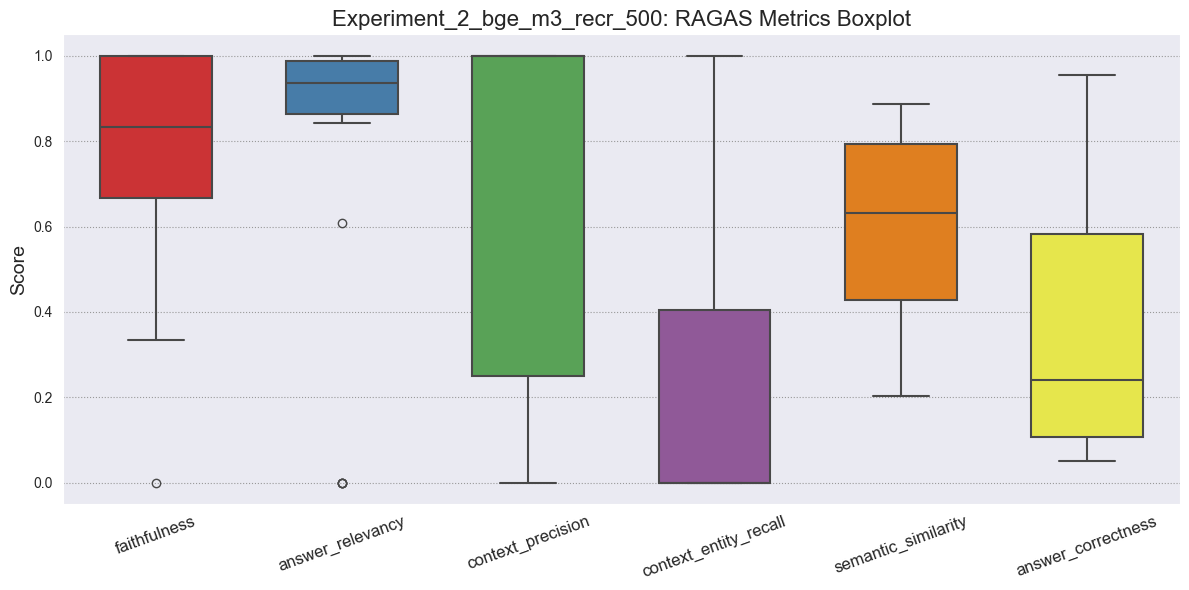

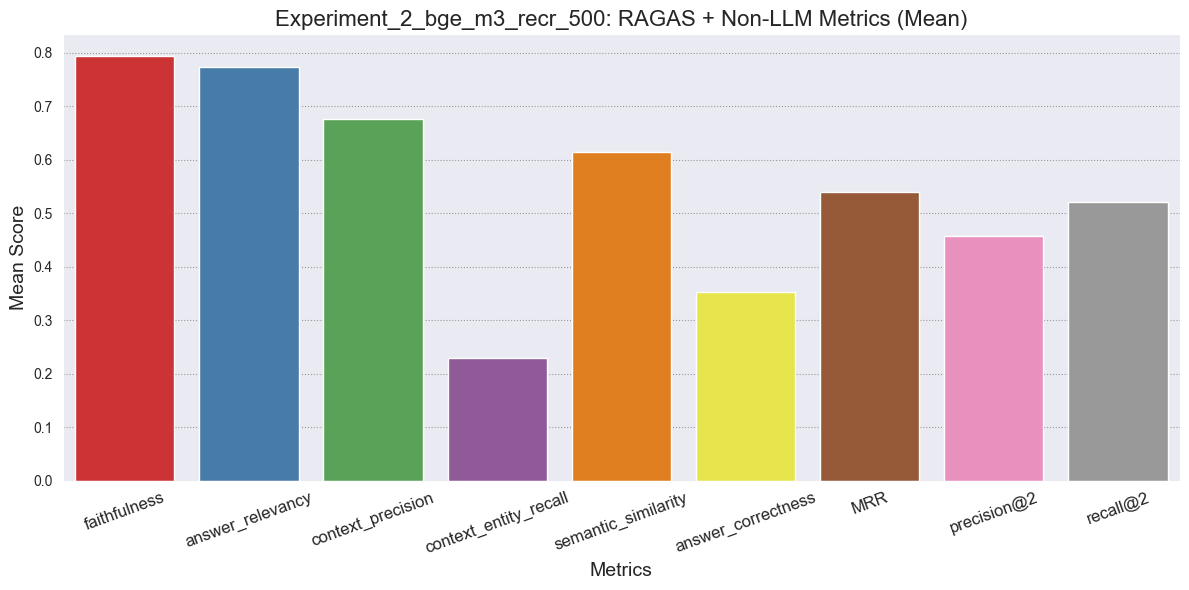

In [27]:
bge_m3_recr_500_evaluation.plot_results_all(result_bge_m3_recr_500)

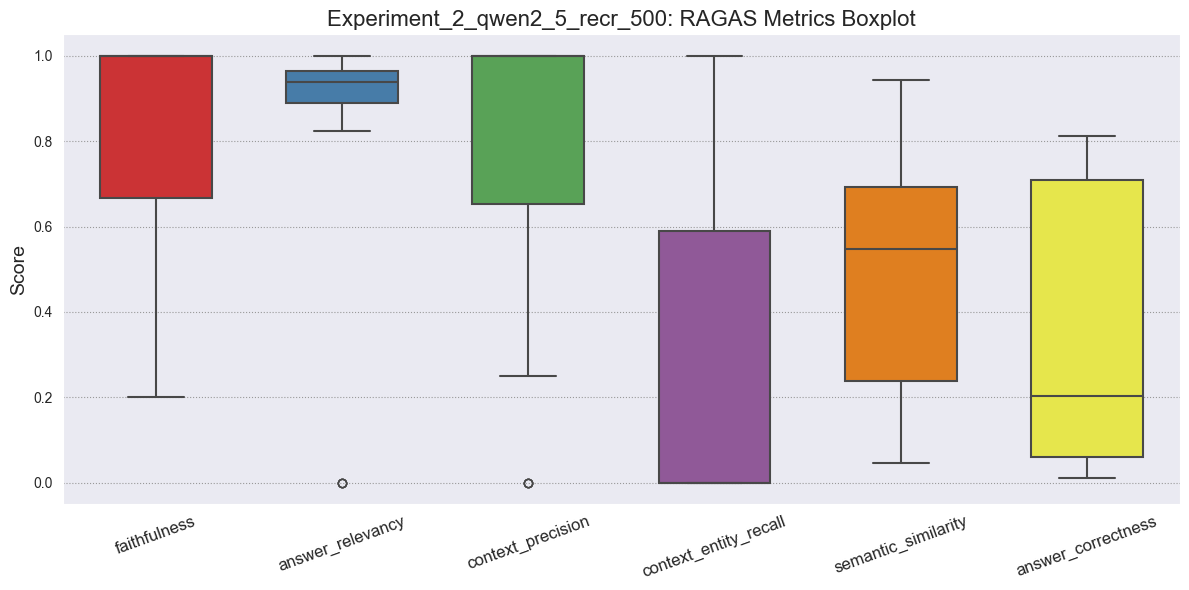

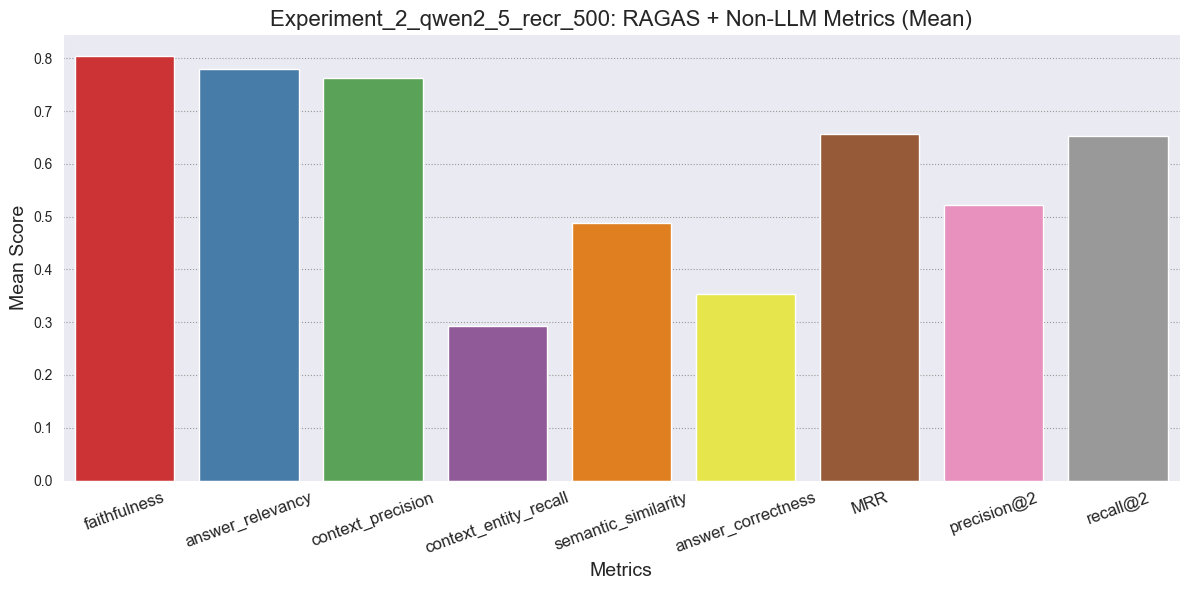

In [28]:
qwen2_5_recr_500_evaluation.plot_results_all(result_qwen2_5_recr_500)

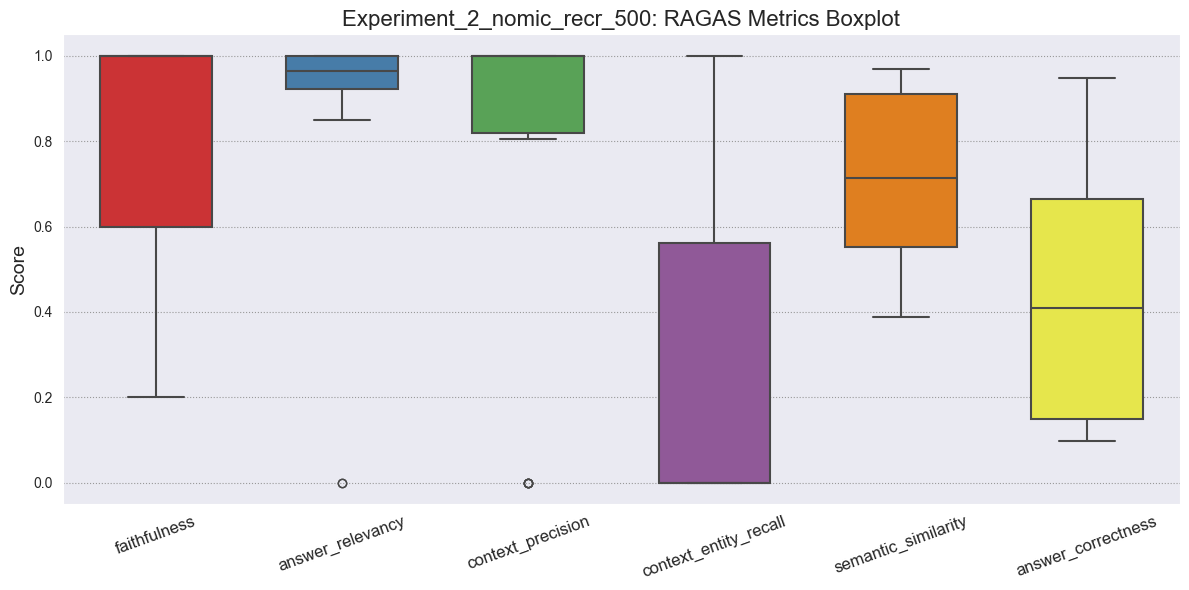

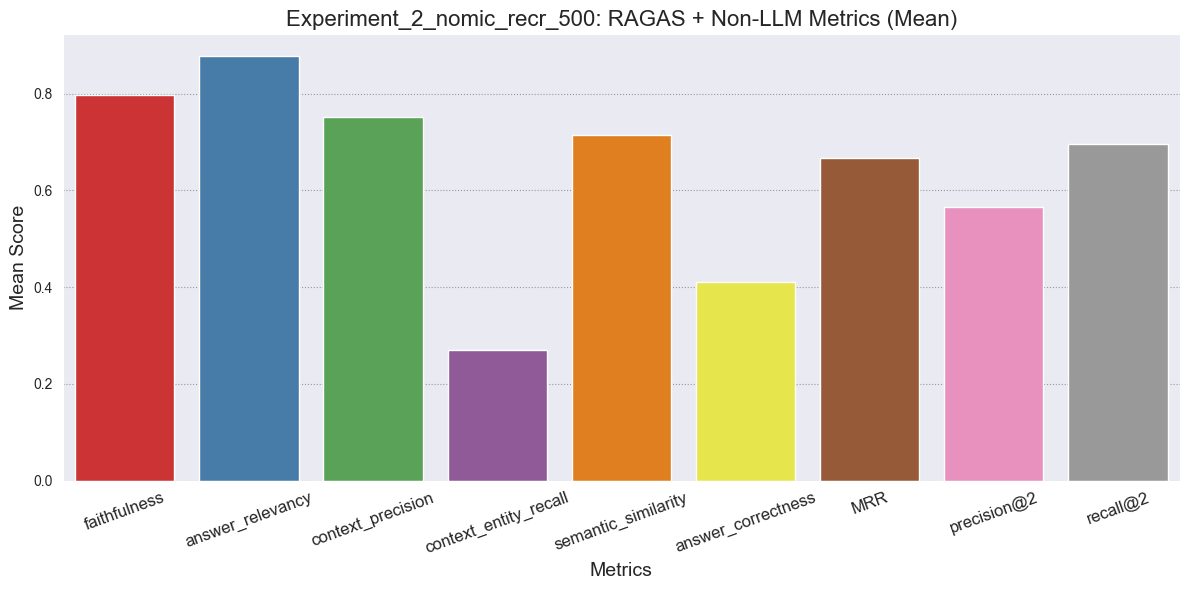

In [38]:
nomic_recr_500_evaluation.plot_results_all(result_nomic_recr_500)

# Semantic Chunker

In [39]:
from langchain_experimental.text_splitter import SemanticChunker

semantic_splitter = SemanticChunker(
    bge_m3_embed,
    breakpoint_threshold_type="percentile",
)

In [40]:
data = pd.read_parquet(str(CLEAN_FILE_PATH))

documents = utils.create_documents(data, semantic_splitter)

SemanticChunker: Documents created: 30642, Rows: 9584, Percentage of doc created: 319.72%


In [42]:
documents[0]

Document(metadata={'url': 'https://www.energyintel.com/0000017b-a7dc-de4c-a17b-e7de685b0000', 'domain': 'energyintel', 'title': 'Qatar to Slash Emissions as LNG Expansion Advances', 'date': '2021-01-13', 'origin_doc_id': '92151dc1d9bfd38bf55079fd769ba2bb'}, page_content='Qatar Petroleum QP is targeting aggressive cuts in its greenhouse gas emissions as it prepares to launch Phase 2 of its planned 48 million ton per year LNG expansion. In its latest Sustainability Report published on Wednesday, QP said its goals include reducing the emissions intensity of Qatar s LNG facilities by 25 and of its upstream facilities by at least 15 . The company is also aiming to reduce gas flaring intensity across its upstream facilities by more than 75 and has raised its carbon capture and storage ambitions from 5 million tons yr to 7 million tons yr by 2027. About 2.2 million tons yr of the carbon capture goal will come from the 32 million ton yr Phase 1 of the LNG expansion, also known as the North Fie

In [43]:
from src.vectorstorage import EmbeddingVectorStorage


def get_col_name_vectordb_sem(embeddings, text_splitter):

    splitter = semantic_splitter.__class__.__name__

    return f"{embeddings.model_name}_{splitter}"


vector_stores = {}

for model in embedding_models:
    collection_name = get_col_name_vectordb_sem(model, recursive_text_splitter)
    print(f"Collection name: {collection_name}")

    vector_storage = EmbeddingVectorStorage(
        method_of_embedding=model,
        collection=collection_name,
    )

    vector_storage.include_documents(documents, should_verbose=True)

    vector_stores[model.model_name] = vector_storage

print(vector_stores)

Collection name: BAAI_bge_m3_SemanticChunker
Group BAAI_bge_m3_SemanticChunker already exists in the vector storage.
Collection name: Alibaba-NLP_gte-Qwen2-7B_SemanticChunker
Group Alibaba-NLP_gte-Qwen2-7B_SemanticChunker already exists in the vector storage.
Collection name: nomic-ai_nomic-embed-text-v1_5_SemanticChunker
Group nomic-ai_nomic-embed-text-v1_5_SemanticChunker already exists in the vector storage.
{'BAAI_bge_m3': VectorStorage(method_of_embedding=CustomHuggingFaceEndpointEmbeddings, group=BAAI_bge_m3_SemanticChunker), 'Alibaba-NLP_gte-Qwen2-7B': VectorStorage(method_of_embedding=CustomHuggingFaceEndpointEmbeddings, group=Alibaba-NLP_gte-Qwen2-7B_SemanticChunker), 'nomic-ai_nomic-embed-text-v1_5': VectorStorage(method_of_embedding=CustomHuggingFaceEndpointEmbeddings, group=nomic-ai_nomic-embed-text-v1_5_SemanticChunker)}


In [44]:
bge_m3_semantic_vectordb = EmbeddingVectorStorage(
    method_of_embedding=bge_m3_embed,
    collection="BAAI_bge_m3_SemanticChunker",
    path_persistent=str(PERSISTENT_DIR),
)

print(
    f"bge_m3_semantic_vectordb Heartbeat: {bge_m3_semantic_vectordb.test_heartbeat()}, bge_m3_semantic_vectordb Collection is empty: {bge_m3_semantic_vectordb.collection_is_empty()}"
)

bge_m3_semantic_vectordb Heartbeat: 1732244529083274000, bge_m3_semantic_vectordb Collection is empty: False


In [45]:
qwen2_5_semantic_vectordb = EmbeddingVectorStorage(
    method_of_embedding=qwen2_embed,
    collection="Alibaba-NLP_gte-Qwen2-7B_SemanticChunker",
    path_persistent=str(PERSISTENT_DIR),
)

print(
    f"qwen2_5_semantic_vectordb Heartbeat: {qwen2_5_semantic_vectordb.test_heartbeat()}, qwen2_5_semantic_vectordb Collection is empty: {qwen2_5_semantic_vectordb.collection_is_empty()}"
)

qwen2_5_semantic_vectordb Heartbeat: 1732244541095946000, qwen2_5_semantic_vectordb Collection is empty: False


In [46]:
nomic_semantic_vectordb = EmbeddingVectorStorage(
    method_of_embedding=nomic_embed,
    collection="nomic-ai_nomic-embed-text-v1_5_SemanticChunker",
    path_persistent=str(PERSISTENT_DIR),
)

print(
    f"nomic_semantic_vectordb Heartbeat: {nomic_semantic_vectordb.test_heartbeat()}, nomic_semantic_vectordb Collection is empty: {nomic_semantic_vectordb.collection_is_empty()}"
)

nomic_semantic_vectordb Heartbeat: 1732244550043849000, nomic_semantic_vectordb Collection is empty: False


In [47]:
bge_m3_semantic_retriever = bge_m3_semantic_vectordb.as_retriever()
qwen2_5_semantic_retriever = qwen2_5_semantic_vectordb.as_retriever()
nomic_semantic_retriever = nomic_semantic_vectordb.as_retriever()

In [48]:
bge_m3_semantic_chain = RunnableParallel(
    {"context": bge_m3_semantic_retriever, "question": RunnablePassthrough()}
).assign(answer=rag_chain_from_docs)

qwen2_5_semantic_chain = RunnableParallel(
    {"context": qwen2_5_semantic_retriever, "question": RunnablePassthrough()}
).assign(answer=rag_chain_from_docs)

nomic_semantic_chain = RunnableParallel(
    {"context": nomic_semantic_retriever, "question": RunnablePassthrough()}
).assign(answer=rag_chain_from_docs)

bge_m3_semantic_chain.invoke("What are the basic recycling steps for solar panels?")

{'context': [Document(metadata={'date': '2023-06-27', 'domain': 'solarindustrymag', 'origin_doc_id': 'f484724e5fdbd04b1a02a6d246361033', 'title': 'Solar Materials Recycling Facility to Serve Southwest', 'url': 'https://solarindustrymag.com/solar-materials-recycling-facility-to-serve-southwest'}, page_content='When fully operational, Mycrogrid Materials Recycling MMR is expected be the largest solar panel recycling facility in the Southwest, assisting California and Arizona in particular with their end of life panels. , MMR will also be the first solar recycling facility in the nation developed in cooperation with a solar installation company, Renova Energy, which is likely to be its biggest supplier of panels to be recycled. , Located in the eastern part of the Coachella Valley in Southern California, MMR will provide recycling services for solar essential materials, including photovoltaic modules, racking and railing and, ultimately, battery storage equipment. , The solar energy revol

In [49]:
qwen2_5_semantic_chain.invoke("What are the basic recycling steps for solar panels?")

{'context': [Document(metadata={'date': '2023-01-12', 'domain': 'solarpowerworldonline', 'origin_doc_id': 'c20859b4d317fade7345d7271336db6b', 'title': 'Entrepreneurs finally bring real sustainability to solar', 'url': 'https://www.solarpowerworldonline.com/2023/01/entrepreneurs-finally-bring-real-sustainability-to-solar/'}, page_content='Back in 2018, one industry source said it was premature to focus on solar panel recycling in the United States, but almost five years later, significant steps are being taken to establish protocols to bring more sustainability to the solar industry. From solar panel recycling to waste cleanup on project sites to better packaging for shipments, the solar industry is greening up its image. , Members of SEIA s PV Recycling Working Group began making recycling checklists and finding preferred partners in 2019, and a grassroots website SolarRecycle.org has collected information on reuse, resale and recycle outlets that accept solar materials. But the bigges

In [50]:
nomic_recr_500_chain.invoke("What are the basic recycling steps for solar panels?")

{'context': [Document(metadata={'date': '2023-03-22', 'domain': 'azocleantech', 'origin_doc_id': 'b41ae19ff4cd9ac9e44e818619e88626', 'title': 'End-of-Life Legislation For Solar Photovoltaic Panels', 'url': 'https://www.azocleantech.com/news.aspx?newsID=33143'}, page_content='easily recycled if they are destroyed or out of warranty. The research was published in the journal AIMS Energy. , Australia has one of the highest uptakes of solar panels in the world, which is outstanding, but little thought has been given to the significant volume of panels ending up in landfill 20 years down the track when they need to be replaced. There are some simple recycling steps that can be taken to reduce the waste volume, including removing the panels frames, glass covers, and'),
  Document(metadata={'date': '2023-06-27', 'domain': 'solarindustrymag', 'origin_doc_id': 'f484724e5fdbd04b1a02a6d246361033', 'title': 'Solar Materials Recycling Facility to Serve Southwest', 'url': 'https://solarindustrymag.c

In [54]:
bge_m3_semantic_evaluation = RAGEvaluation(
    name="Experiment_2_bge_m3_semantic",
    rag_chain=bge_m3_semantic_chain,
    llm_model=openai_llm_model,
    local_llm=local_llm_model.model,
    embeddings=bge_m3_embed,
)

result_bge_m3_semantic = bge_m3_semantic_evaluation.evaluate(
    clean_file, eval_file, bge_m3_semantic_vectordb
)

Loading cached data from: /Users/arian/Documents/FHNW/npr/npr_hs_24/npr_mc1_new_hs24/npr-mc1-frfr/data/cache/Experiment_2_bge_m3_semantic_qwen2.5:3b-instruct_BAAI_bge_m3_gpt-4o-mini_eval_result.pkl


In [55]:
qwen2_5_semantic_evaluation = RAGEvaluation(
    name="Experiment_2_qwen2_5_semantic",
    rag_chain=qwen2_5_semantic_chain,
    llm_model=openai_llm_model,
    local_llm=local_llm_model.model,
    embeddings=qwen2_embed,
)

result_qwen2_5_semantic = qwen2_5_semantic_evaluation.evaluate(
    clean_file, eval_file, qwen2_5_semantic_vectordb
)

Loading cached data from: /Users/arian/Documents/FHNW/npr/npr_hs_24/npr_mc1_new_hs24/npr-mc1-frfr/data/cache/Experiment_2_qwen2_5_semantic_qwen2.5:3b-instruct_Alibaba-NLP_gte-Qwen2-7B_gpt-4o-mini_eval_result.pkl


In [56]:
nomic_semantic_evaluation = RAGEvaluation(
    name="Experiment_2_nomic_semantic",
    rag_chain=nomic_semantic_chain,
    llm_model=openai_llm_model,
    local_llm=local_llm_model.model,
    embeddings=nomic_embed,
)

result_nomic_semantic = nomic_semantic_evaluation.evaluate(
    clean_file, eval_file, nomic_semantic_vectordb
)

Loading cached data from: /Users/arian/Documents/FHNW/npr/npr_hs_24/npr_mc1_new_hs24/npr-mc1-frfr/data/cache/Experiment_2_nomic_semantic_qwen2.5:3b-instruct_nomic-ai_nomic-embed-text-v1_5_gpt-4o-mini_eval_result.pkl


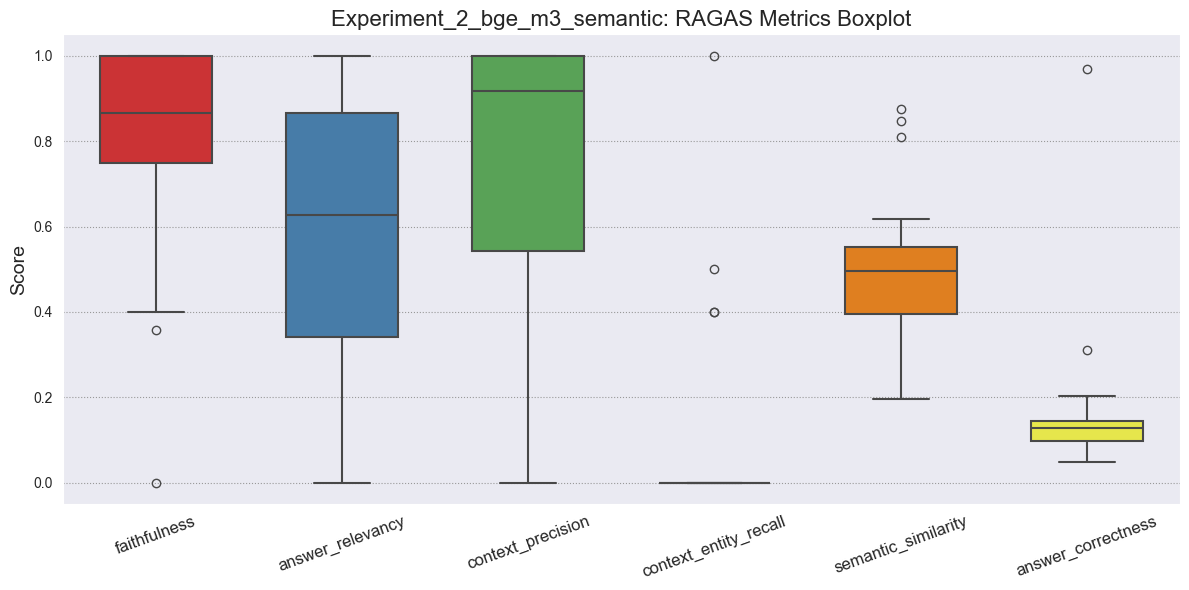

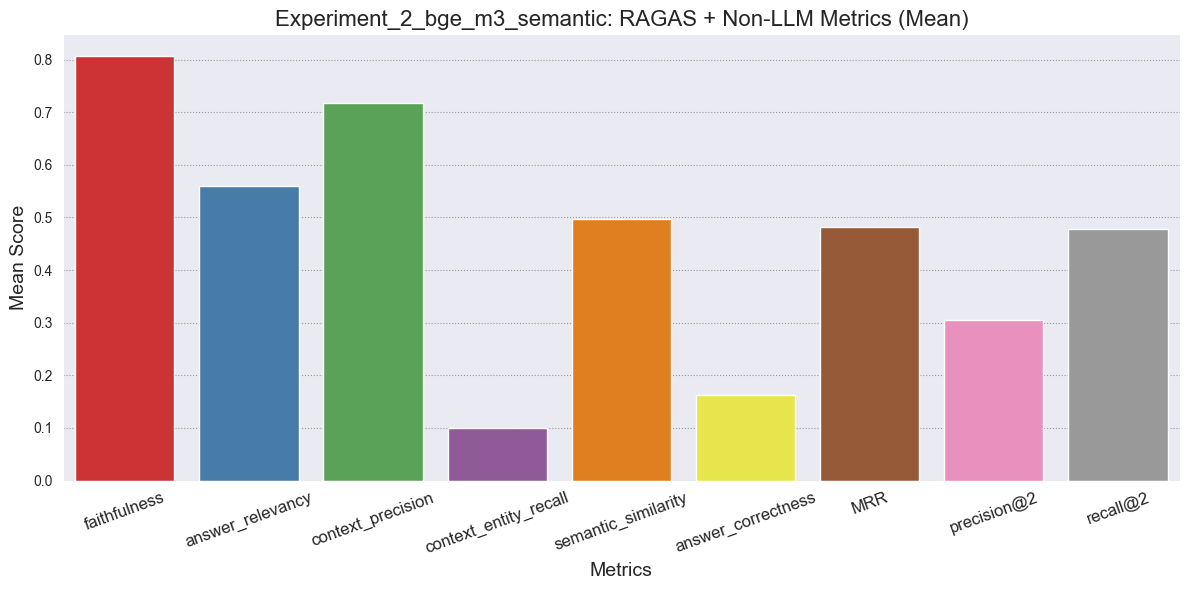

In [57]:
bge_m3_semantic_evaluation.plot_results_all(result_bge_m3_semantic)

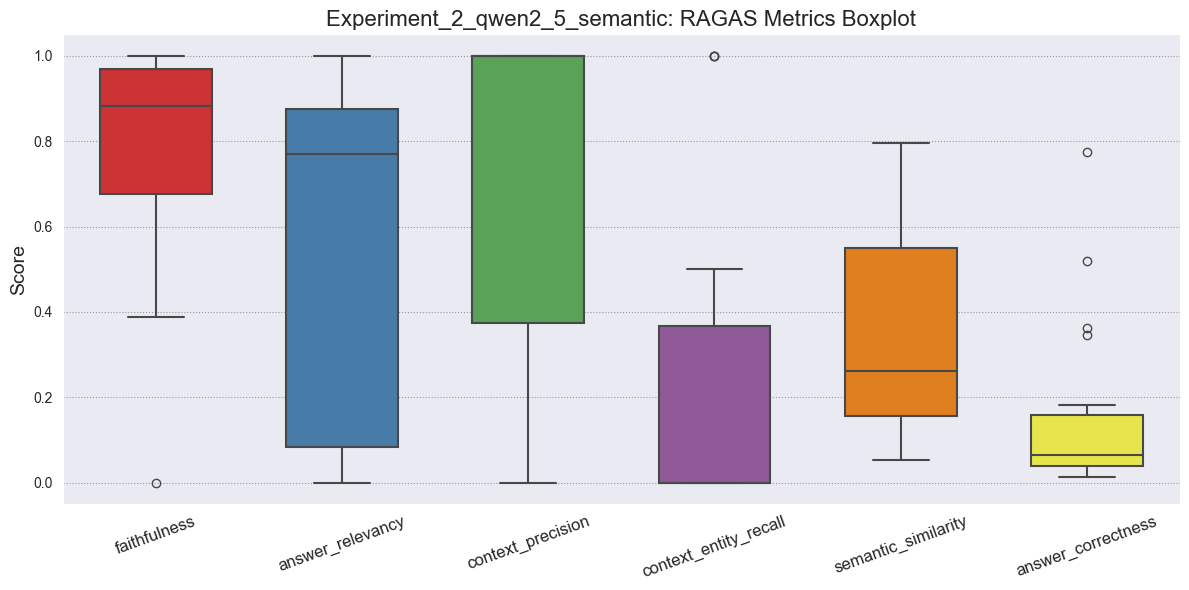

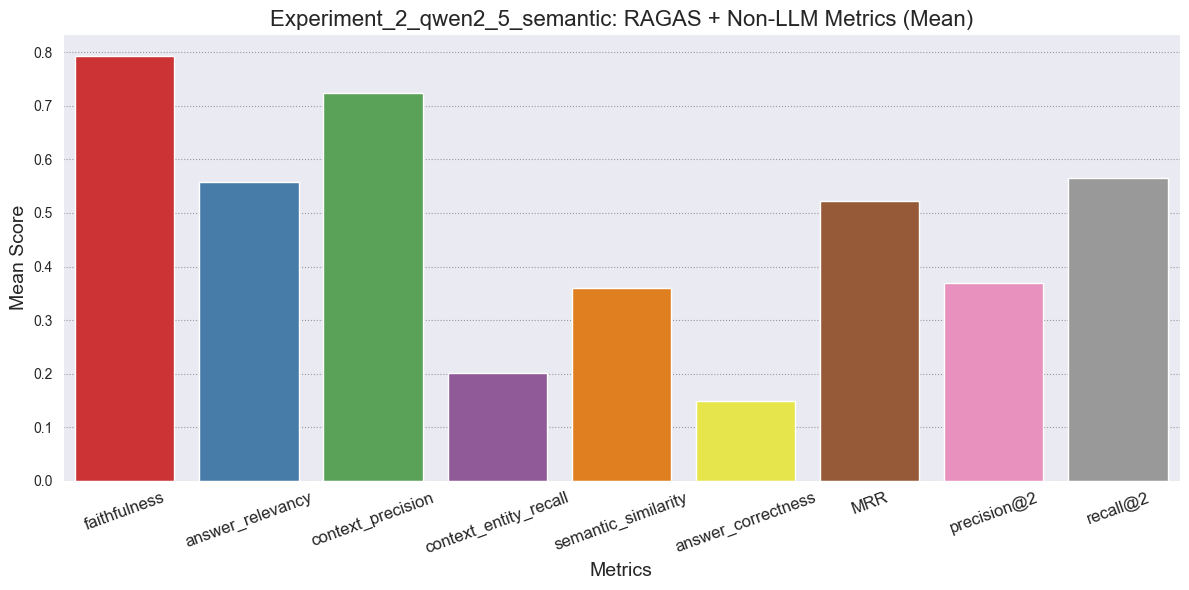

In [58]:
qwen2_5_semantic_evaluation.plot_results_all(result_qwen2_5_semantic)

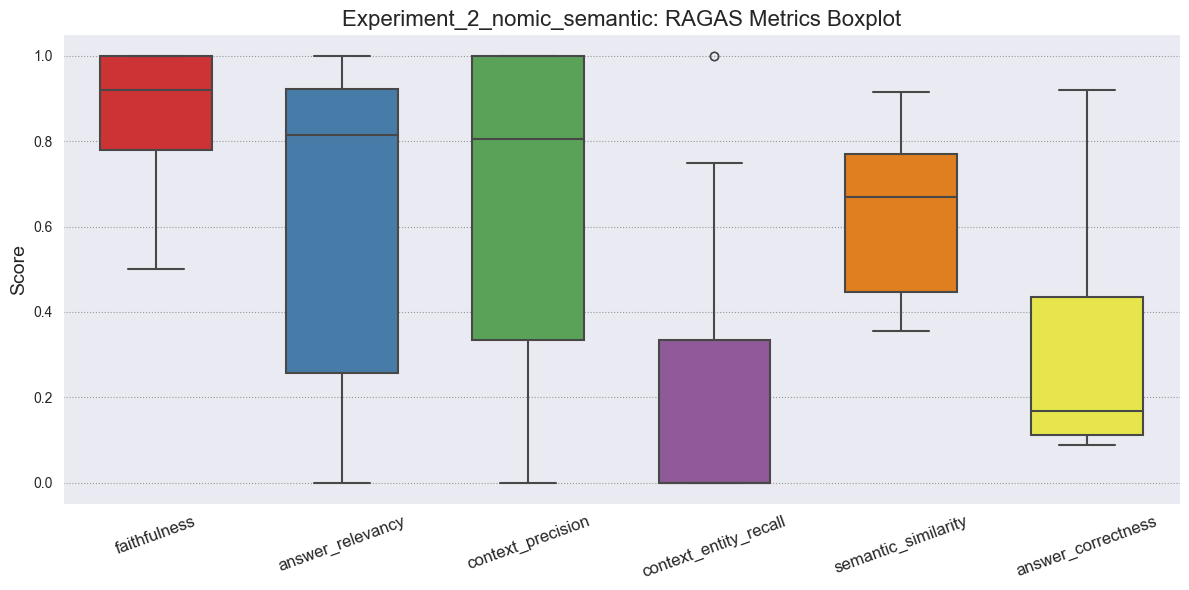

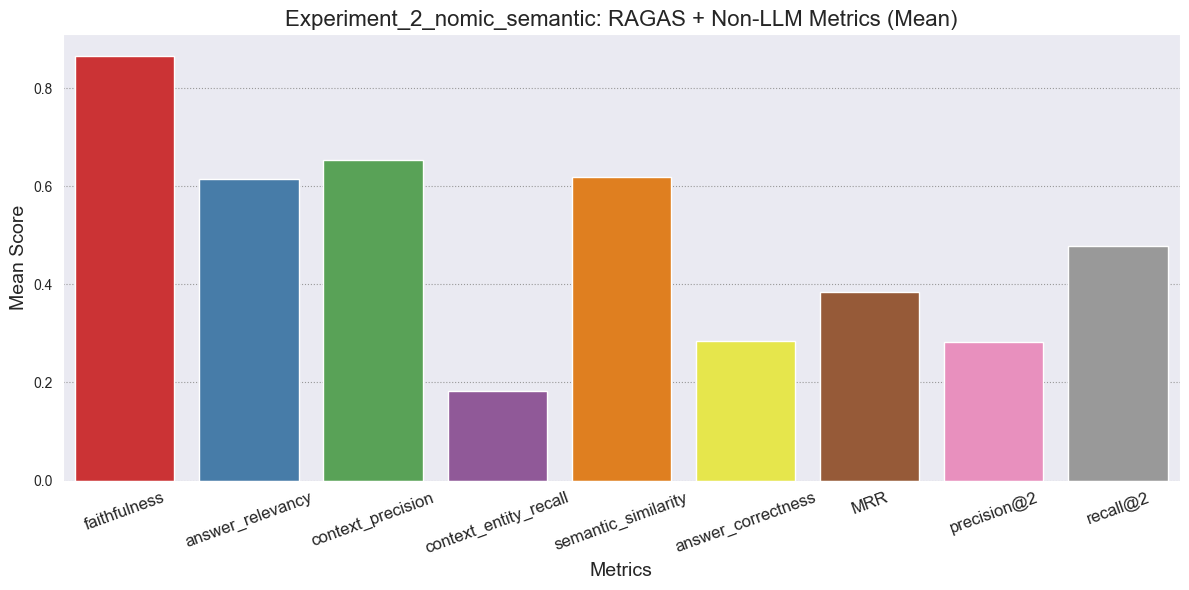

In [59]:
nomic_semantic_evaluation.plot_results_all(result_nomic_semantic)